In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IS3107/combined_v4.csv')
print(df.shape)
pd.set_option('display.max_columns', 100)
df.head(3)

(6922, 26)


,Unnamed: 0,Application_link,Title,Company,Salary,Type,Availability_requests,Requirements_short,Description,Requirements_full,Responsibilities,Field,Date_scraped,Salary_min_month,Salary_max_month,Data_source,Location,Size,Founded,Industry,Sector,Revenue,Created_date,Job_id,Is_internship,priority
0,0,https://sg.indeed.com/applystart?jk=002ef6cf70...,Research Assistant (Image Analysis),Nanyang Technological University,NaN,Full-time,NaN,Experienced in image processing and machine le...,The School of Electrical and Electronic Engine...,Bachelor Degree in Computer Science or Electri...,"Study literatures on PCB security evaluation, ...",Machine learning engineer,2024-04-21,NaN,NaN,Indeed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,https://sg.indeed.com/applystart?jk=002ef6cf70...,Research Assistant (Image Analysis),Nanyang Technological University,NaN,Full-time,NaN,Experienced in image processing and machine le...,The School of Electrical and Electronic Engine...,Bachelor Degree in Computer Science or Electri...,"Study literatures on PCB security evaluation, ...",Machine learning engineer,2024-04-21,NaN,NaN,Indeed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2,https://sg.indeed.com/applystart?jk=003044653d...,Senior Data Engineer,Commonwealth Bank,NaN,Full-time,NaN,Build and implement data pipelines in distribu...,"Organization: At CommBank, we never lose sight...",A degree in Engineering / Computer Science or ...,Design and develop highly reliable and scalabl...,Data engineer,2024-04-20,NaN,NaN,Indeed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# Data prep

In [ ]:
df_clean = df.copy()

## Handling NaNs

In [ ]:
# get rid of cols that are irrelevant to salary prediction
df_clean = df_clean.drop(['Created_date', 'Job_id', 'Founded', 'Revenue', 'Application_link'], axis=1) # revenue and founded corresponds to the company anyway, not needed

In [ ]:
# initial nan count
print(df_clean.isna().sum())

Unnamed: 0                  0
Title                       5
Company                   781
Salary                   4143
Type                     2551
Availability_requests    6708
Requirements_short       2579
Description                 0
Requirements_full        3220
Responsibilities         4111
Field                      42
Date_scraped                0
Salary_min_month         3737
Salary_max_month         3737
Data_source                 0
Location                 5440
Size                     5547
Industry                 5547
Sector                   5547
Is_internship            5835
priority                    0
dtype: int64


In [ ]:
# we cannot make salary predictions on jobs that don't even salary data. hence, drop rows without salary data
df_clean = df_clean.dropna(subset=['Salary_min_month'])

# drop original salary col
df_clean = df_clean.drop(['Salary'], axis=1)
print(df_clean.shape)

(3185, 20)


In [ ]:
# handle nans in non-numeric cols
non_numeric_cols = ['Company', 'Requirements_short', 'Requirements_full', 'Type',
       'Responsibilities', 'Location', 'Industry', 'Sector', 'Availability_requests', 'Size']
for i in non_numeric_cols:
  df_clean[i] = df_clean[i].fillna('Unknown') # since the information is unknown, we should literally fill nans up with "Unknown"

# handling 'Field' -- since it only has 21 nans, we will impute with the most common title, which is software engineer
df_clean['Field'] = df_clean['Field'].fillna('Software engineer')

In [ ]:
# drop Title, bcos Field already contains the parsed form
df_clean = df_clean.drop(['Title'], axis=1)

In [ ]:
# handle nans in numeric cols
df_clean['Is_internship'] = df_clean['Is_internship'].fillna(0)

In [ ]:
# final nan count
print(df_clean.isna().sum())

Unnamed: 0               0
Company                  0
Type                     0
Availability_requests    0
Requirements_short       0
Description              0
Requirements_full        0
Responsibilities         0
Field                    0
Date_scraped             0
Salary_min_month         0
Salary_max_month         0
Data_source              0
Location                 0
Size                     0
Industry                 0
Sector                   0
Is_internship            0
priority                 0
dtype: int64


## Handling dtypes

In [ ]:
# initial dtypes
print(df_clean.dtypes)

Unnamed: 0                 int64
Company                   object
Type                      object
Availability_requests     object
Requirements_short        object
Description               object
Requirements_full         object
Responsibilities          object
Field                     object
Date_scraped              object
Salary_min_month         float64
Salary_max_month         float64
Data_source               object
Location                  object
Size                      object
Industry                  object
Sector                    object
Is_internship            float64
priority                   int64
dtype: object


In [ ]:
df_clean2 = df_clean.copy()

In [ ]:
# Drop Data_source -- irrelevant
df_clean2 = df_clean2.drop(['Data_source'], axis=1)
df_clean2 = df_clean2.drop(['Unnamed: 0'], axis=1)

In [ ]:
df_clean2['Date_scraped'] = pd.to_datetime(df_clean2['Date_scraped'])
df_clean2['Field'] = df_clean2['Field'].str.replace("[^a-zA-Z\s]", "", regex=True)

In [ ]:
# since description is derived from requirements, drop requirements col
df_clean2 = df_clean2.drop(['Requirements_short', 'Requirements_full'], axis=1)

## handling categorical variables

In [ ]:
# checking which cols are categorical
print(df_clean2.nunique())

Company                   882
Type                       27
Availability_requests       9
Description              2006
Responsibilities          464
Field                      51
Date_scraped               12
Salary_min_month          190
Salary_max_month          227
Location                   21
Size                        8
Industry                   49
Sector                     24
Is_internship               2
priority                    3
dtype: int64


In [ ]:
# binning for categorical variables

# checking current value counts for these categorical variables
cat = ['Type', 'Location', 'Size', 'Sector', 'Availability_requests', 'Industry', 'Company'] # we will handle 'Field' separately from the rest due to different preprocessing needed

for i in cat:
  print(f'Value counts for column: {i}')
  print(df_clean2[i].value_counts())
  print('*'*50)

Value counts for column: Type
Type
Unknown                           1209
Full-time                          434
Full-time                          389
Company - Private                  365
Permanent                          307
Contract                           168
Company - Public                   139
Internship                          34
Temporary                           27
Full-time +2                        23
Fresh graduate                      15
On call                             12
Subsidiary or Business Segment       9
Shift system                         8
Part-time                            7
Weekend availability                 6
Permanent                            6
Self-employed                        5
College / University                 4
Temporary                            3
Internship                           3
On call                              3
Non-profit Organisation              3
Part-time                            2
Hospital                     

In [ ]:
# handling the binning

# for highly imbalanced categories, it is not meaningful to keep these columns, since the values should be the same for almost the whole dataset
# in some cases, e.g. Location, it is indeed the same Location for the whole dataset (Singapore). But due to recording differences between different platforms, there are different categories showing up

# drop these categories
df_clean2 = df_clean2.drop(['Availability_requests', 'Sector', 'Location', 'Size', 'Industry', 'Company'], axis=1)

In [ ]:
# re-binning for 'Type'
df_clean2['Job_Type'] = np.where(
    df_clean2['Type'].str.contains('Full'), 'Full time',
      np.where(df_clean2['Type'].str.contains('Perm'), 'Contract',
        np.where(df_clean2['Type'].str.contains('Unknown'), 'Unknown',
          np.where(df_clean2['Type'].str.contains('Fresh graduate'), 'Full time',
            'Contract'))))

# drop original 'Type' column
df_clean2 = df_clean2.drop(['Type'], axis=1)

# checking final Job_Type binning
print(df_clean2['Job_Type'].value_counts())

Job_Type
Unknown      1209
Contract     1115
Full time     861
Name: count, dtype: int64


In [ ]:
# handling 'Field'
print(df_clean2['Field'].value_counts())

Field
Software engineer                           594
Data analyst                                412
Data engineer                               274
Data architect                              272
Business analyst                            255
Machine learning engineer                   221
Data scientist                              191
data                                        161
data engineer                               126
Database administrator                      113
Data modeler                                110
Business intelligence developer              78
Quantitative analyst                         75
data analyst                                 63
Statistician                                 58
Marketing scientist                          46
Computer  information research scientist     32
data scientist                               32
data architect                               16
engineer                                     10
analyst                           

In [ ]:
df_clean2['Job_Field'] = np.where(
    df_clean2['Field'].str.contains('analyst', case=False), 'data analyst',
      np.where(df_clean2['Field'].str.contains('scientist', case=False), 'data scientist',
        np.where((df_clean2['Field'].str.contains('data engineer', case=False)) | (df_clean2['Field'].str.contains('machine learning engineer', case=False)), 'data engineer',
          np.where(df_clean2['Field'].str.contains('architect', case=False), 'data architect',
            np.where(df_clean2['Field'].str.contains('database', case=False), 'database administrator',
              np.where((df_clean2['Field'].str.contains('software engineer', case=False)) | (df_clean2['Field'].str.contains('developer', case=False)), 'software engineer', 'Others')
                # while 'Others' may seem very vague, from our list of filtered keywords, we know that these are all still data-related jobs.
)))))

# drop original 'Field' column
df_clean2 = df_clean2.drop(['Field'], axis=1)

# checking final Job_Field binning
print(df_clean2['Job_Field'].value_counts())

Job_Field
data analyst              821
software engineer         674
data engineer             626
Others                    358
data scientist            304
data architect            289
database administrator    113
Name: count, dtype: int64


In [ ]:
# handling 'Description'

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the Text
vectorizer = CountVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(df_clean2['Description'])  # Document-term matrix

# Fit LDA Model
lda = LatentDirichletAllocation(n_components=10, random_state=0)  # Assuming we want to find 10 topics
lda_features = lda.fit_transform(dtm)

# Print the topics
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx + 1))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
               for i in topic.argsort()[:-top_n - 1:-1]])
print_topics(lda, vectorizer)

Topic 1:
[('data', 1465.2908255804107), ('database', 1016.0047280245775), ('business', 499.1652442053332), ('management', 431.06304447648154), ('experience', 414.47111493261536), ('requirements', 366.8045277617893), ('analysis', 331.6956932979724), ('performance', 292.3727418680214), ('systems', 277.8933521083867), ('sql', 268.6572173874965)]
Topic 2:
[('ai', 990.4155696842782), ('learning', 872.4322678346015), ('experience', 708.3938830207348), ('machine', 668.8899280664031), ('data', 461.7485667701095), ('bytedance', 433.668502018801), ('team', 405.42978765792975), ('models', 386.867492825991), ('ml', 341.0198706146803), ('solutions', 322.0093405266292)]
Topic 3:
[('tiktok', 2468.3768556124874), ('experience', 1648.2691505011458), ('data', 1536.4650804164226), ('team', 1134.289830269533), ('mission', 955.3813988920484), ('bring', 853.9363327877321), ('inspire', 846.5129366568596), ('platform', 845.6867696508822), ('job', 814.5714051067517), ('creativity', 790.6918034726352)]
Topic 4:

In [ ]:
# just take the highest probability topic as a feature for simplicity
df_clean2['Dominant_Topic'] = np.argmax(lda_features, axis=1)

# drop original Description column
df_clean2 = df_clean2.drop(['Description'], axis=1)

In [ ]:
# drop Responsibities
df_clean2 = df_clean2.drop(['Responsibilities'], axis=1)

In [ ]:
# create a new salary column, which is the midpoint of salary_min and salary_max, so that we only have 1 variable to predict
df_clean2['Salary_midpoint'] = (df_clean2['Salary_min_month'] + df_clean2['Salary_max_month']) / 2

# drop original salary columns
df_clean2 = df_clean2.drop(['Salary_min_month', 'Salary_max_month'], axis=1)
df_clean2.head(3)

,Date_scraped,Is_internship,priority,Job_Type,Job_Field,Dominant_Topic,Salary_midpoint
2334,2024-04-12,0.0,3,Unknown,data engineer,3,5250.0
2342,2024-04-21,0.0,3,Unknown,data engineer,5,5500.0
2360,2024-04-20,0.0,3,Unknown,data analyst,5,7250.0


In [ ]:
# drop date column -- not doing time series
df_clean2 = df_clean2.drop(['Date_scraped'], axis=1)

In [ ]:
df_clean2['Is_internship'] = df_clean2['Is_internship'].astype('int')

In [ ]:
df_clean2.head()

,Is_internship,priority,Job_Type,Job_Field,Dominant_Topic,Salary_midpoint
2334,0,3,2,3,3,5250.0
2342,0,3,2,3,5,5500.0
2360,0,3,2,1,5,7250.0
2371,0,3,2,3,5,6250.0
2388,0,3,2,1,9,5000.0


In [ ]:
df_clean2.corr()

,Is_internship,priority,Job_Type,Job_Field,Dominant_Topic,Salary_midpoint
Is_internship,1.000000,0.123316,0.069910,-0.065322,-0.000727,0.002101
priority,0.123316,1.000000,0.261089,-0.183905,0.080768,0.317770
Job_Type,0.069910,0.261089,1.000000,-0.135614,-0.068585,0.255049
Job_Field,-0.065322,-0.183905,-0.135614,1.000000,-0.097240,-0.099770
Dominant_Topic,-0.000727,0.080768,-0.068585,-0.097240,1.000000,-0.128310
Salary_midpoint,0.002101,0.317770,0.255049,-0.099770,-0.128310,1.000000


<Axes: xlabel='Salary_midpoint'>

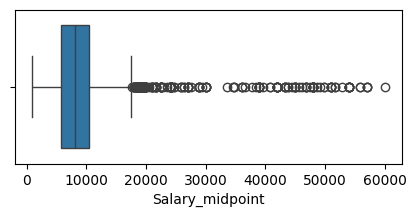

In [ ]:
import seaborn as sns
plt.figure(figsize=(5, 2))
sns.boxplot(data=df_clean2, x='Salary_midpoint')

# Machine Learning :D

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_clean2['Job_Type'] = label_encoder.fit_transform(df_clean2['Job_Type'])
df_clean2['Job_Field'] = label_encoder.fit_transform(df_clean2['Job_Field'])

In [ ]:
# scaling target
from sklearn.preprocessing import MinMaxScaler

X = df_clean2.drop(['Salary_midpoint'], axis=1)
y = df_clean2['Salary_midpoint']

scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y.values.reshape(-1, 1))

In [ ]:
# train test split -- no need val since we are only using 1 model and our dataset so small
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3025, 5)
(3025, 1)
(160, 5)
(160, 1)


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

random_forest_regressor = RandomForestRegressor(
                              n_estimators=500,
                              max_depth=None,
                              max_features='sqrt',
                              random_state=42)
random_forest_regressor.fit(X_train, y_train)

<ipython-input-139-293f53fa4eab>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_regressor.fit(X_train, y_train)


RandomForestRegressor(max_features='sqrt', n_estimators=500, random_state=42)

In [ ]:
# Make predictions for test set
y_pred = random_forest_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("Test R squared:", r2)

Mean Squared Error: 0.020351466867741926
Test R squared: 0.190941674749871


In [ ]:
# Evaluation on train seet
y_pred_train = random_forest_regressor.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error:", mse)
r2 = r2_score(y_train, y_pred_train)
print("Train R squared:", r2)

Mean Squared Error: 0.009451169782126857
Train R squared: 0.3867804328133494


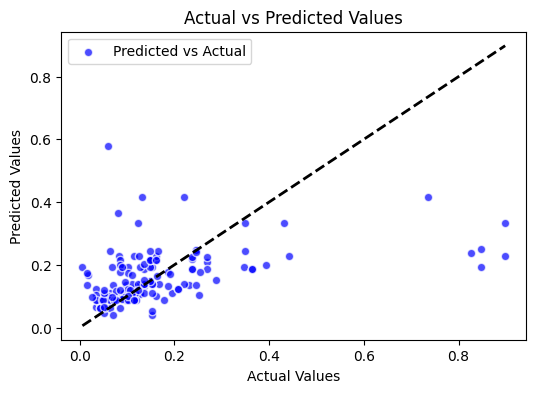

In [ ]:
import matplotlib.pyplot as plt

# Actual vs Predicted scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolors='w', label='Predicted vs Actual')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.legend()
plt.show()

# Remove outliers

In [ ]:
df_clean2.head()

,Is_internship,priority,Job_Type,Job_Field,Dominant_Topic,Salary_midpoint
2334,0,3,2,3,3,5250.0
2342,0,3,2,3,5,5500.0
2360,0,3,2,1,5,7250.0
2371,0,3,2,3,5,6250.0
2388,0,3,2,1,9,5000.0


In [ ]:
Q1 = df_clean2['Salary_midpoint'].quantile(0.25)
Q3 = df_clean2['Salary_midpoint'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean_no_outliers = df_clean2[(df_clean2['Salary_midpoint'] >= lower_bound) & (df_clean2['Salary_midpoint'] <= upper_bound)]

print(df_clean_no_outliers.shape)
df_clean_no_outliers.head()

(2985, 6)


,Is_internship,priority,Job_Type,Job_Field,Dominant_Topic,Salary_midpoint
2334,0,3,2,3,3,5250.0
2342,0,3,2,3,5,5500.0
2360,0,3,2,1,5,7250.0
2371,0,3,2,3,5,6250.0
2388,0,3,2,1,9,5000.0


In [ ]:
# scaling target
from sklearn.preprocessing import MinMaxScaler

X = df_clean_no_outliers.drop(['Salary_midpoint'], axis=1)
y = df_clean_no_outliers['Salary_midpoint']

scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y.values.reshape(-1, 1))

In [ ]:
# train test split -- no need val since we are only using 1 model and our dataset so small
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2835, 5)
(2835, 1)
(150, 5)
(150, 1)


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

random_forest_regressor = RandomForestRegressor(
                              n_estimators=700,
                              max_depth=10,
                              max_features='log2',
                              warm_start=True,
                              random_state=42)
random_forest_regressor.fit(X_train, y_train)

<ipython-input-167-83b7a83ab132>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_regressor.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=700,
                      random_state=42, warm_start=True)

In [ ]:
# Make predictions for test set
y_pred = random_forest_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("Test R squared:", r2)

print('*'*50)

# Evaluation on train seet
y_pred_train = random_forest_regressor.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error:", mse)
r2 = r2_score(y_train, y_pred_train)
print("Train R squared:", r2)

Mean Squared Error: 0.02737585491205313
Test R squared: 0.4149560509905632
**************************************************
Mean Squared Error: 0.026726094669194206
Train R squared: 0.46414409955154434


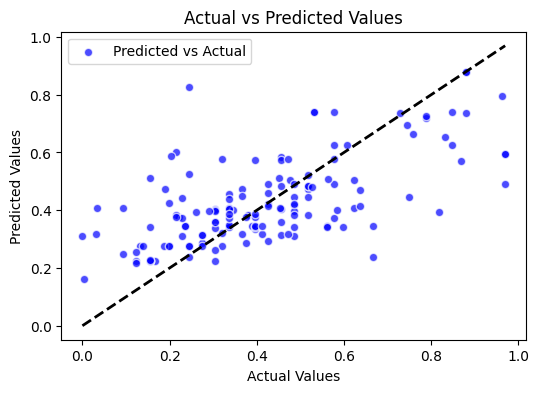

In [ ]:
import matplotlib.pyplot as plt

# Actual vs Predicted scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolors='w', label='Predicted vs Actual')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.legend()
plt.show()